In [39]:
import torch
from torch import nn
from torch.optim import AdamW
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
import torch.nn.functional as F
import timm
import optim
from torch.optim.lr_scheduler import StepLR
import seaborn as sns

In [40]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

Is CUDA available:  True
Num GPUs Available:  1


In [41]:
# Define transformations
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    # transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    # transforms.RandomRotation(10),  # Random rotation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter for augmentation
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformations
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

# Load the dataset with applied transformations
full_dataset = ImageFolder('data', transform=common_transforms)

# Define dataset split sizes as proportions (0 to 1)
train_prop = 0.7
val_prop = 0.15
test_prop = 1 - train_prop - val_prop  # Ensure all data is used

# Calculate actual sizes based on full dataset length
full_dataset_len = len(full_dataset)  # Assuming you know the length of full_dataset
train_size = int(train_prop * full_dataset_len)
val_size = int(val_prop * full_dataset_len)
test_size = full_dataset_len - train_size - val_size  # Might be redundant but ensures all data

train_dataset_full, val_dataset_full, test_dataset_full = random_split(full_dataset, [train_size, val_size, test_size])

# subsampling for faster training
subsample_ratio = 0.1  # Subsample 50% of the training data

train_dataset, _ = random_split(train_dataset_full, [subsample_ratio, 1-subsample_ratio])
val_dataset, _ = random_split(val_dataset_full, [subsample_ratio, 1-subsample_ratio])
test_dataset, _ = random_split(test_dataset_full, [subsample_ratio, 1-subsample_ratio])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Squeeze and Excitation Block

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torch.optim import AdamW

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [43]:
import torch
from torch.optim import AdamW
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy
from torch import nn
import torch.nn.functional as F

class CustomSENet(LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super(CustomSENet, self).__init__()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SEBlock(256),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 28 * 28, num_classes)  # Adjust size based on your input image dimensions
        )
        self.criterion = nn.CrossEntropyLoss()

        # # Freeze all parameters first
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # # Unfreeze the parameters of the last linear layer
        # if isinstance(self.model[-1], nn.Linear):
        #     for param in self.model[-1].parameters():
        #         param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(logits, y))
        return {'loss': loss, 'val_acc': self.accuracy(logits, y)}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))
        return {'loss': loss, 'test_acc': self.accuracy(logits, y)}

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

In [44]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Directory where the checkpoints will be saved
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,  # Save only the best checkpoint
    verbose=True,
    monitor="val_loss",  # Metric to monitor
    mode="min",  # Minimize the monitored metric (val_loss)
    save_last=True  # Additionally, save the last model state at the end of training
)

In [45]:
model = CustomSENet()
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback in training
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | accuracy  | MulticlassAccuracy | 0     
1 | model     | Sequential         | 4.4 M 
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.586    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s, v_num=70, train_acc=0.0385]

Epoch 0, global step 40: 'val_loss' reached 9.43698 (best 9.43698), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=00-val_loss=9.44.ckpt' as top 1


Epoch 1: 100%|██████████| 40/40 [00:18<00:00,  2.22it/s, v_num=70, train_acc=0.403] 

Epoch 1, global step 80: 'val_loss' reached 3.95599 (best 3.95599), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=01-val_loss=3.96.ckpt' as top 1


Epoch 2: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s, v_num=70, train_acc=0.333]

Epoch 2, global step 120: 'val_loss' reached 3.77602 (best 3.77602), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=02-val_loss=3.78.ckpt' as top 1


Epoch 3: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s, v_num=70, train_acc=0.542]

Epoch 3, global step 160: 'val_loss' reached 3.52097 (best 3.52097), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=03-val_loss=3.52.ckpt' as top 1


Epoch 4: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s, v_num=70, train_acc=0.600]

Epoch 4, global step 200: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s, v_num=70, train_acc=0.440]

Epoch 5, global step 240: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s, v_num=70, train_acc=0.818]

Epoch 6, global step 280: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 40/40 [00:19<00:00,  2.00it/s, v_num=70, train_acc=0.667]

Epoch 7, global step 320: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s, v_num=70, train_acc=0.778]

Epoch 8, global step 360: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 40/40 [00:19<00:00,  2.03it/s, v_num=70, train_acc=0.909]

Epoch 9, global step 400: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s, v_num=70, train_acc=0.909]


In [46]:
print(model)

CustomSENet(
  (accuracy): MulticlassAccuracy()
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): SEBlock(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
        (3): Sigmoid()
      )
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): SEBlock(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
    

In [47]:
# # Load the best model from checkpoint
model = CustomSENet.load_from_checkpoint(checkpoint_path=trainer.checkpoint_callback.best_model_path)

# Test the model
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.19834329187870026
        test_loss            3.380714178085327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.380714178085327, 'test_acc': 0.19834329187870026}]

In [48]:
import pandas as pd
data7 = {
    'Epoch': list(range(10)),
    'train_acc': [0.0385, 0.403, 0.333, 0.542, 0.600, 0.440, 0.818, 0.667, 0.778, 0.909],
    'val_loss': [9.43698, 3.95599, 3.77602, 3.52097, None, None, None, None, None, None]  # val_loss is only provided for epochs where it was mentioned as the best or top
}

# Creating DataFrame
df7 = pd.DataFrame(data7)
df7.head()

,Epoch,train_acc,val_loss
0,0,0.0385,9.43698
1,1,0.4030,3.95599
2,2,0.3330,3.77602
3,3,0.5420,3.52097
4,4,0.6000,NaN


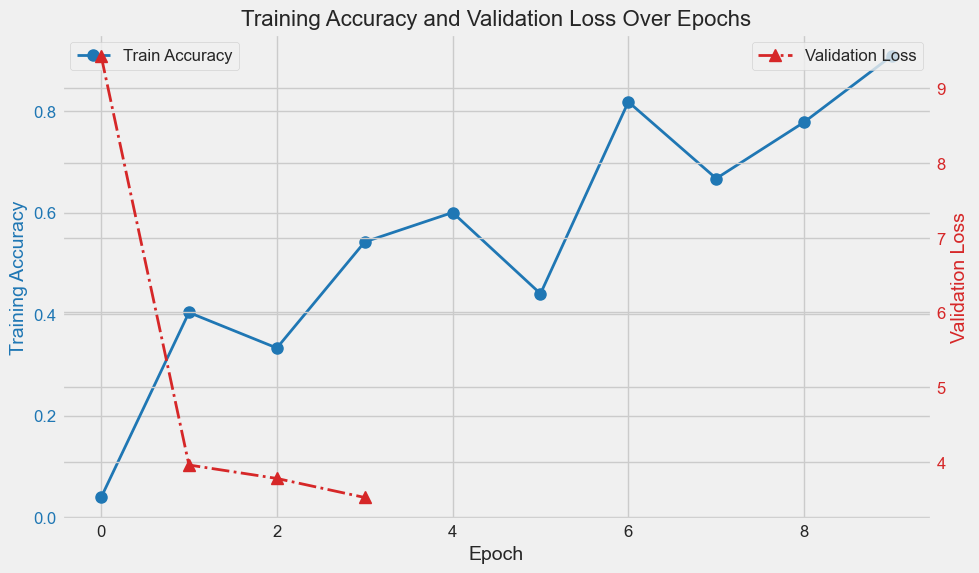

In [49]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', color='tab:blue', fontsize=14)
line1, = ax1.plot(df7['Epoch'], df7['train_acc'], label='Train Accuracy', color='tab:blue', marker='o', markersize=8, linestyle='-', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(handles=[line1], loc='upper left', fontsize=12)

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', color='tab:red', fontsize=14)
valid_epochs = df7.dropna(subset=['val_loss'])
line2, = ax2.plot(valid_epochs['Epoch'], valid_epochs['val_loss'], label='Validation Loss', color='tab:red', marker='^', markersize=8, linestyle='-.', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=12)
ax2.legend(handles=[line2], loc='upper right', fontsize=12)
plt.title('Training Accuracy and Validation Loss Over Epochs', fontsize=16)
plt.show()

## Deit Transfromer Model

In [5]:
class TransformerModel(pl.LightningModule):
    def __init__(self, model_name, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

        for param in self.model.parameters():
            param.requires_grad = False

        last_block = next(reversed(self.model.blocks))
        for param in last_block.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)  
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [10]:
deit_model = TransformerModel('deit_base_patch16_224', num_classes=20)
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback]  
)
trainer.fit(deit_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory D:\MSBA sem 2\advanced ML\project\src\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | VisionTransformer  | 85.8 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s, v_num=57, train_acc=0.667, val_loss=0.828, val_acc=0.679]

Epoch 0, global step 40: 'val_loss' reached 0.82849 (best 0.82849), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=00-val_loss=0.83.ckpt' as top 1


Epoch 1: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s, v_num=57, train_acc=1.000, val_loss=0.672, val_acc=0.766]

Epoch 1, global step 80: 'val_loss' reached 0.67195 (best 0.67195), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=01-val_loss=0.67.ckpt' as top 1


Epoch 2: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s, v_num=57, train_acc=0.944, val_loss=0.602, val_acc=0.762]

Epoch 2, global step 120: 'val_loss' reached 0.60242 (best 0.60242), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=02-val_loss=0.60.ckpt' as top 1


Epoch 3: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s, v_num=57, train_acc=1.000, val_loss=0.603, val_acc=0.741]

Epoch 3, global step 160: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s, v_num=57, train_acc=1.000, val_loss=0.597, val_acc=0.738]

Epoch 4, global step 200: 'val_loss' reached 0.59722 (best 0.59722), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=04-val_loss=0.60.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s, v_num=57, train_acc=1.000, val_loss=0.597, val_acc=0.738]


In [7]:
print(deit_model)

TransformerModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='no

In [12]:
model = TransformerModel.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
    model_name='deit_base_patch16_224'  
)

trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7990036606788635
        test_loss           0.3952936828136444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3952936828136444, 'test_acc': 0.7990036606788635}]

In [26]:
data5 = {
    'Epoch': list(range(5)),
    'train_acc': [0.667, 1.000, 0.944, 1.000, 1.000],
    'val_loss': [0.828, 0.672, 0.602, 0.603, 0.597],
    'val_acc': [0.679, 0.766, 0.762, 0.741, 0.738]
}

df5 = pd.DataFrame(data5)
df5.head()

,Epoch,train_acc,val_loss,val_acc
0,0,0.667,0.828,0.679
1,1,1.000,0.672,0.766
2,2,0.944,0.602,0.762
3,3,1.000,0.603,0.741
4,4,1.000,0.597,0.738


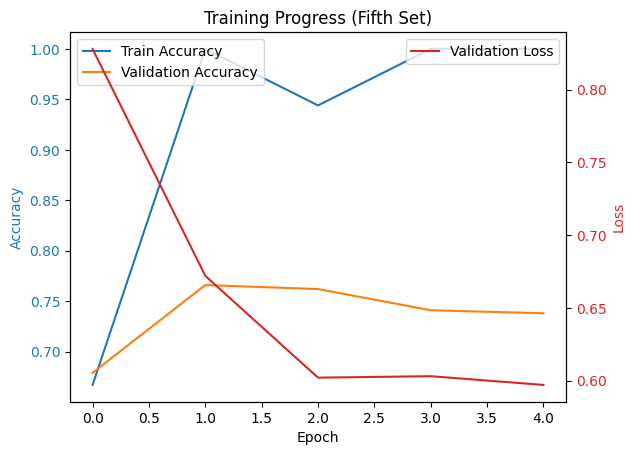

In [30]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(df5['Epoch'], df5['train_acc'], label='Train Accuracy', color='tab:blue')
ax1.plot(df5['Epoch'], df5['val_acc'], label='Validation Accuracy', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(df5['Epoch'], df5['val_loss'], label='Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Training Progress (Fifth Set)')
plt.show()


In [13]:
model.eval()
model.freeze()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)  
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    return all_preds, all_labels

predictions, labels = evaluate_model(model, test_loader)
print(classification_report(labels, predictions))
predictions, labels = evaluate_model(model, test_loader)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.75      0.90      0.82        10
           2       0.86      0.82      0.84        22
           3       0.95      0.95      0.95        20
           4       0.82      0.82      0.82        22
           5       1.00      0.91      0.95        11
           6       0.91      1.00      0.95        10
           7       0.88      0.78      0.82         9
           8       0.86      0.82      0.84        22
           9       0.83      0.94      0.88        16
          10       0.75      0.38      0.50         8
          11       0.86      0.86      0.86         7
          12       0.78      0.70      0.74        10
          13       1.00      0.91      0.95        11
          14       0.91      0.77      0.83        13
          15       1.00      0.88      0.93         8
          16       0.78      1.00      0.88         7
          17       0.88    

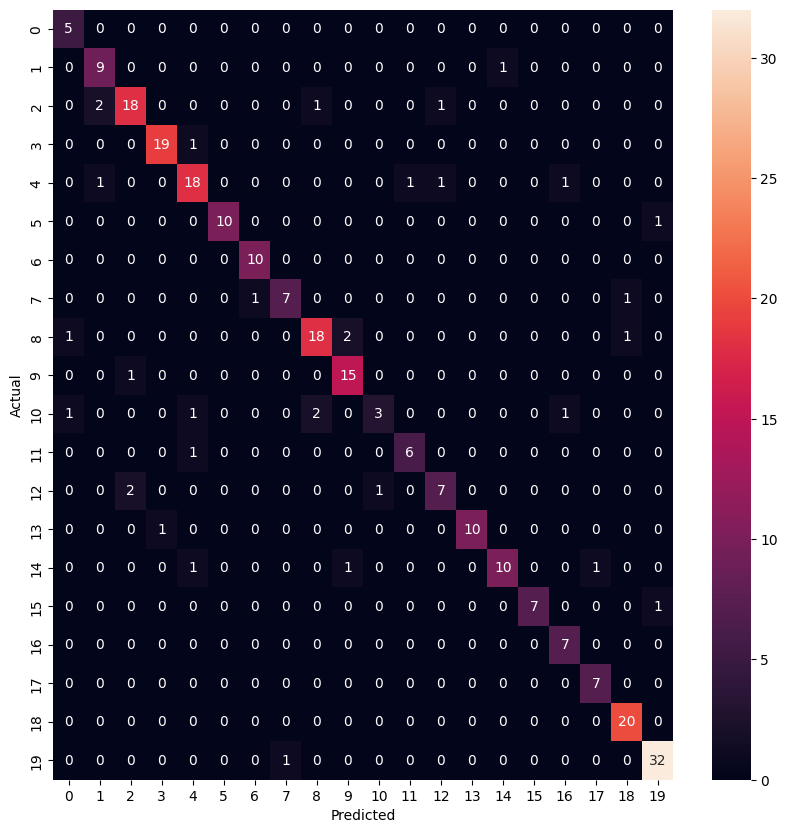

In [15]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(labels, predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


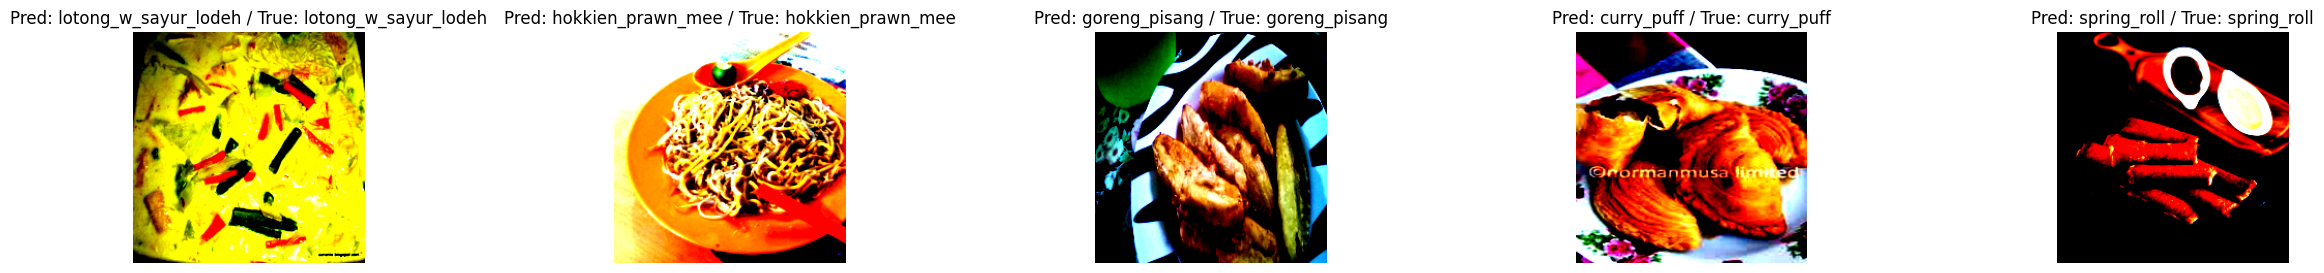

In [16]:
import matplotlib.pyplot as plt
dataset = datasets.ImageFolder('data')
label_names = dataset.classes 

def visualize_predictions(model, test_loader, label_names, num_images=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)  
    model.eval()  

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(30, 3))
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)  

    logits = model(images)
    preds = torch.argmax(logits, dim=1)

    for i, ax in enumerate(axes):
        if i >= num_images:  
            break
        img = images[i].cpu().permute(1, 2, 0)
        ax.imshow(img.numpy())
        pred_label = label_names[preds[i].item()]  
        true_label = label_names[labels[i].item()]
        ax.set_title(f'Pred: {pred_label} / True: {true_label}')
        ax.axis('off')
    
    plt.show()
visualize_predictions(model, test_loader, label_names)

In [19]:
import numpy as np
def get_model_probabilities(model, loader, device):
    model.to(device)
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)  
            probabilities = torch.softmax(model(images), dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return np.concatenate(all_probs, axis=0), np.concatenate(all_labels, axis=0)
model_scores, labels = get_model_probabilities(model, test_loader, 'cuda' if torch.cuda.is_available() else 'cpu')

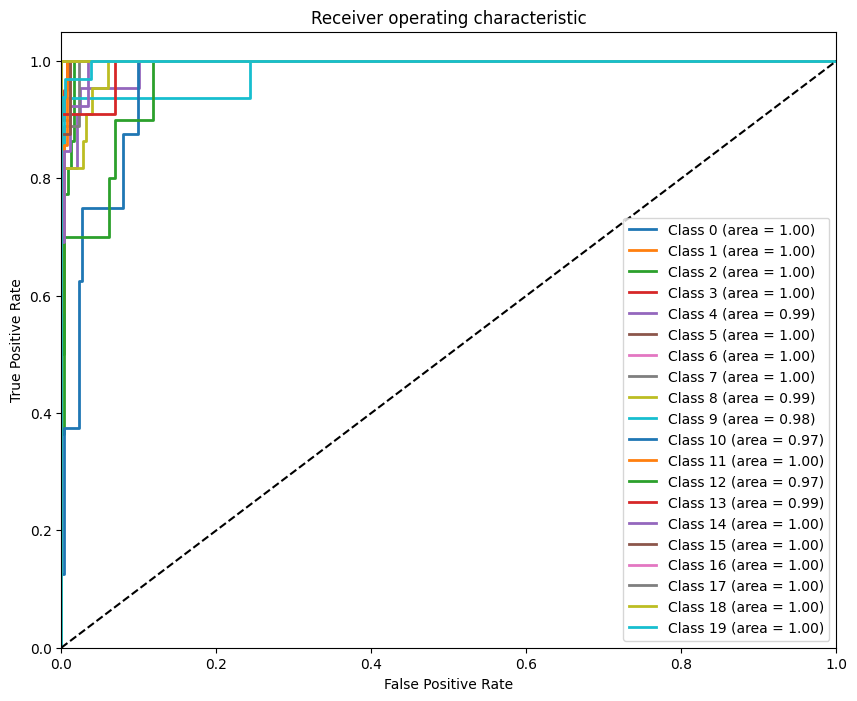

In [21]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, scores, num_classes):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((labels == i).astype(int), scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(labels, model_scores, len(label_names))

## VIT Transformer

In [14]:
class TransformerModel(pl.LightningModule):
    def __init__(self, model_name, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

        for param in self.model.parameters():
            param.requires_grad = False

        last_block = next(reversed(self.model.blocks))
        for param in last_block.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)  # Adjust step_size and gamma as needed
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [15]:
vit_model = TransformerModel('vit_base_patch16_224', num_classes=20)
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback]  
)
trainer.fit(vit_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | VisionTransformer  | 85.8 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
7.1 M     Trainable params
78.7 M    Non-trainable params
85.8 M    Total params
343.256   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Epoch 0: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, v_num=60, train_acc=0.633, val_loss=0.952, val_acc=0.664]

Epoch 0, global step 40: 'val_loss' reached 0.95244 (best 0.95244), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=00-val_loss=0.95.ckpt' as top 1


Epoch 1: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s, v_num=60, train_acc=0.833, val_loss=0.713, val_acc=0.723]

Epoch 1, global step 80: 'val_loss' reached 0.71313 (best 0.71313), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=01-val_loss=0.71.ckpt' as top 1


Epoch 2: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s, v_num=60, train_acc=1.000, val_loss=0.749, val_acc=0.815]

Epoch 2, global step 120: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 40/40 [00:23<00:00,  1.67it/s, v_num=60, train_acc=1.000, val_loss=0.676, val_acc=0.808]

Epoch 3, global step 160: 'val_loss' reached 0.67602 (best 0.67602), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=03-val_loss=0.68.ckpt' as top 1


Epoch 4: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s, v_num=60, train_acc=1.000, val_loss=0.678, val_acc=0.828]

Epoch 4, global step 200: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, v_num=60, train_acc=1.000, val_loss=0.678, val_acc=0.828]


In [17]:
print(vit_model)

TransformerModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='no

In [16]:
model = TransformerModel.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
    model_name='vit_base_patch16_224'  
)
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7888444066047668
        test_loss           0.7745846509933472
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7745846509933472, 'test_acc': 0.7888444066047668}]

In [37]:
data4 = {
    'Epoch': list(range(5)),
    'train_acc': [0.633, 0.833, 1.000, 1.000, 1.000],
    'val_loss': [0.952, 0.713, 0.749, 0.676, 0.678],
    'val_acc': [0.664, 0.723, 0.815, 0.808, 0.828]
}
df4 = pd.DataFrame(data4)
df4.head()

,Epoch,train_acc,val_loss,val_acc
0,0,0.633,0.952,0.664
1,1,0.833,0.713,0.723
2,2,1.000,0.749,0.815
3,3,1.000,0.676,0.808
4,4,1.000,0.678,0.828


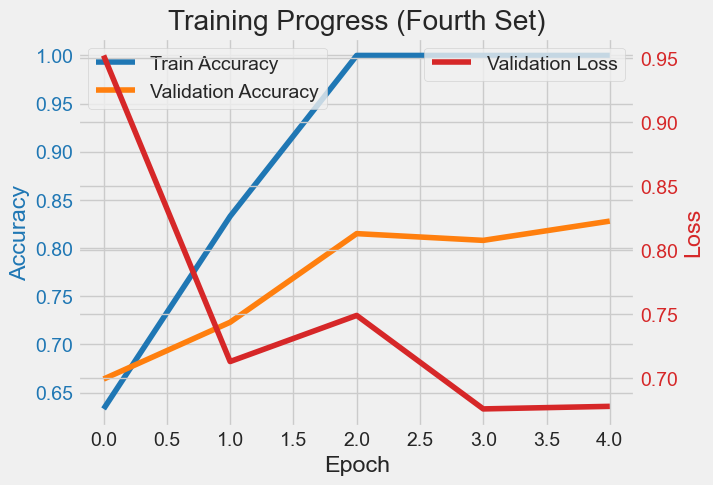

In [38]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(df4['Epoch'], df4['train_acc'], label='Train Accuracy', color='tab:blue')
ax1.plot(df4['Epoch'], df4['val_acc'], label='Validation Accuracy', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(df4['Epoch'], df4['val_loss'], label='Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Training Progress (Fourth Set)')
plt.show()

## Swin Transformer

In [18]:
import torch
from torch import nn
from transformers import SwinForImageClassification, ConvNextForImageClassification, AutoFeatureExtractor
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torch.optim import AdamW

In [20]:
import torch.nn as nn
import pytorch_lightning as pl
from transformers import SwinForImageClassification, AutoFeatureExtractor
from torch.optim import AdamW
from torchmetrics import Accuracy

class SwinTransformer(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")
        self.model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224")

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

    def forward(self, x):
        outputs = self.model(x).logits
        return outputs

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', self.accuracy(logits, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(logits, y), prog_bar=True)
        return {'test_loss': loss, 'test_acc': self.accuracy(logits, y)}

    def configure_optimizers(self):
        optimizer = AdamW(self.model.classifier.parameters(), lr=self.hparams.learning_rate)
        return optimizer

In [21]:
model = SwinTransformer()
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback]  
)
trainer.fit(model, train_loader, val_loader)

c:\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | SwinForImageClassification | 86.8 M
1 | criterion | CrossEntropyLoss           | 0     
2 | accuracy  | MulticlassAccuracy         | 0     
---------------------------------------------------------
20.5 K    Trainable params
86.7 M    Non-trainable params
86.8 M    Total params
347.055   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s, v_num=61, train_loss_step=1.030, train_acc_step=0.650, val_loss=0.796, val_acc=0.774, train_loss_epoch=1.590, train_acc_epoch=0.559]

Epoch 0, global step 40: 'val_loss' was not in top 1


Epoch 1: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s, v_num=61, train_loss_step=0.288, train_acc_step=1.000, val_loss=0.531, val_acc=0.822, train_loss_epoch=0.533, train_acc_epoch=0.864]

Epoch 1, global step 80: 'val_loss' reached 0.53098 (best 0.53098), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=01-val_loss=0.53.ckpt' as top 1


Epoch 2: 100%|██████████| 40/40 [00:24<00:00,  1.65it/s, v_num=61, train_loss_step=0.217, train_acc_step=0.800, val_loss=0.463, val_acc=0.840, train_loss_epoch=0.355, train_acc_epoch=0.895]

Epoch 2, global step 120: 'val_loss' reached 0.46282 (best 0.46282), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=02-val_loss=0.46.ckpt' as top 1


Epoch 3: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, v_num=61, train_loss_step=0.502, train_acc_step=0.733, val_loss=0.431, val_acc=0.840, train_loss_epoch=0.272, train_acc_epoch=0.922]

Epoch 3, global step 160: 'val_loss' reached 0.43118 (best 0.43118), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=03-val_loss=0.43.ckpt' as top 1


Epoch 4: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s, v_num=61, train_loss_step=0.410, train_acc_step=0.778, val_loss=0.415, val_acc=0.845, train_loss_epoch=0.217, train_acc_epoch=0.952]

Epoch 4, global step 200: 'val_loss' reached 0.41455 (best 0.41455), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=04-val_loss=0.41.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s, v_num=61, train_loss_step=0.410, train_acc_step=0.778, val_loss=0.415, val_acc=0.845, train_loss_epoch=0.217, train_acc_epoch=0.952]


In [22]:
model = SwinTransformer.load_from_checkpoint(checkpoint_path=trainer.checkpoint_callback.best_model_path)
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8598547577857971
        test_loss            0.375608891248703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.375608891248703, 'test_acc': 0.8598547577857971}]

In [22]:
data3 = {
    'Epoch': list(range(5)),
    'train_loss_step': [1.030, 0.288, 0.217, 0.502, 0.410],
    'train_acc_step': [0.650, 1.000, 0.800, 0.733, 0.778],
    'val_loss': [0.796, 0.531, 0.463, 0.431, 0.415],
    'val_acc': [0.774, 0.822, 0.840, 0.840, 0.845],
    'train_loss_epoch': [1.590, 0.533, 0.355, 0.272, 0.217],
    'train_acc_epoch': [0.559, 0.864, 0.895, 0.922, 0.952]
}

df3 = pd.DataFrame(data3)
df3.head()

,Epoch,train_loss_step,train_acc_step,val_loss,val_acc,train_loss_epoch,train_acc_epoch
0,0,1.030,0.650,0.796,0.774,1.590,0.559
1,1,0.288,1.000,0.531,0.822,0.533,0.864
2,2,0.217,0.800,0.463,0.840,0.355,0.895
3,3,0.502,0.733,0.431,0.840,0.272,0.922
4,4,0.410,0.778,0.415,0.845,0.217,0.952


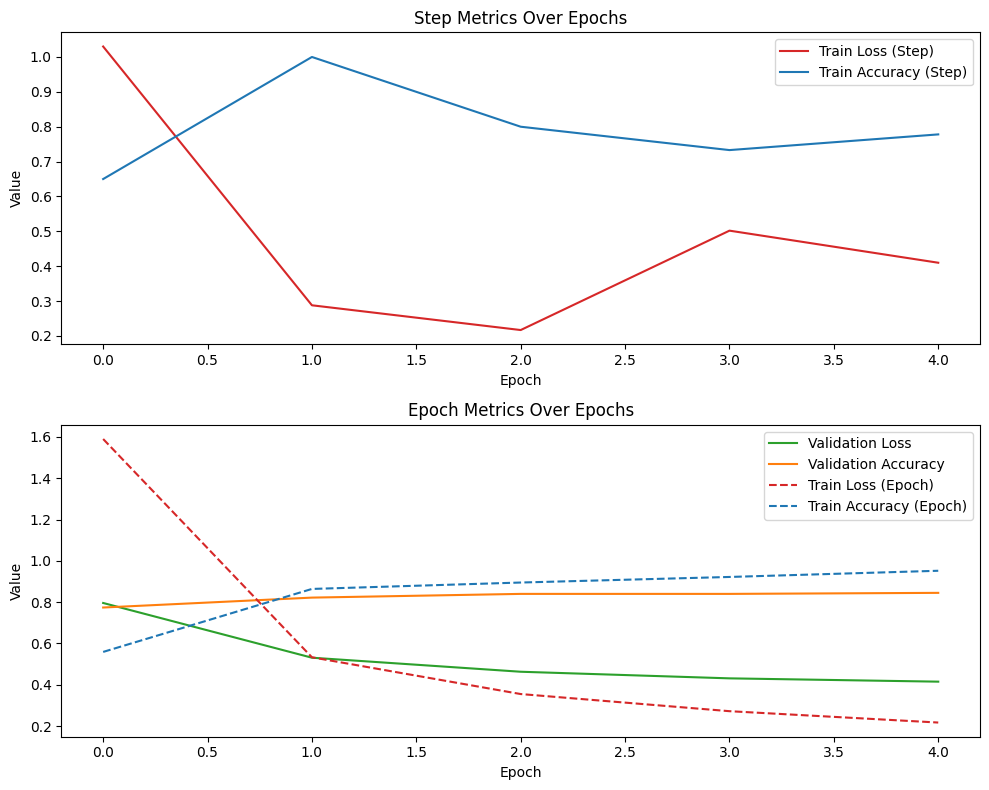

In [23]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.set_title('Step Metrics Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.plot(df3['Epoch'], df3['train_loss_step'], label='Train Loss (Step)', color='tab:red')
ax1.plot(df3['Epoch'], df3['train_acc_step'], label='Train Accuracy (Step)', color='tab:blue')
ax1.legend(loc='upper right')

ax2.set_title('Epoch Metrics Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.plot(df3['Epoch'], df3['val_loss'], label='Validation Loss', color='tab:green')
ax2.plot(df3['Epoch'], df3['val_acc'], label='Validation Accuracy', color='tab:orange')
ax2.plot(df3['Epoch'], df3['train_loss_epoch'], label='Train Loss (Epoch)', color='tab:red', linestyle='dashed')
ax2.plot(df3['Epoch'], df3['train_acc_epoch'], label='Train Accuracy (Epoch)', color='tab:blue', linestyle='dashed')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [31]:
print(model)

SwinTransformer(
  (model): SwinForImageClassification(
    (swin): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=128, out_features=128, bias=True)
                    (key): Linear(in_features=128, out_features=128, bias=True)
                    (value): Linear(in_features=128, out_features=128, bias=True)
                    (dropout): Dropout(p=0.0, 

In [23]:
model.eval()
model.freeze()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)  
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    return all_preds, all_labels

predictions, labels = evaluate_model(model, test_loader)
print(classification_report(labels, predictions))

predictions, labels = evaluate_model(model, test_loader)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.85      0.79      0.81        14
           2       0.87      0.83      0.85        24
           3       0.96      0.96      0.96        28
           4       0.88      1.00      0.94        15
           5       0.93      0.88      0.90        16
           6       0.93      1.00      0.97        14
           7       0.91      0.91      0.91        11
           8       0.82      0.90      0.86        10
           9       0.50      1.00      0.67         3
          10       0.83      0.77      0.80        13
          11       1.00      0.83      0.91         6
          12       0.72      0.87      0.79        15
          13       1.00      0.88      0.93        16
          14       0.90      0.75      0.82        12
          15       0.80      1.00      0.89         4
          16       1.00      0.88      0.94        17
          17       0.88    

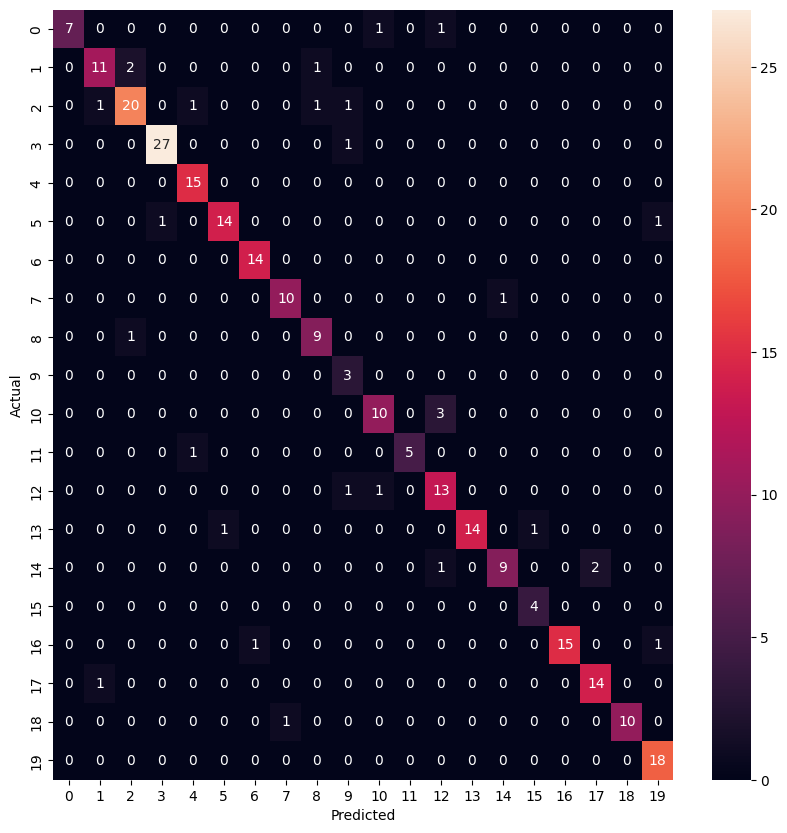

In [25]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(labels, predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


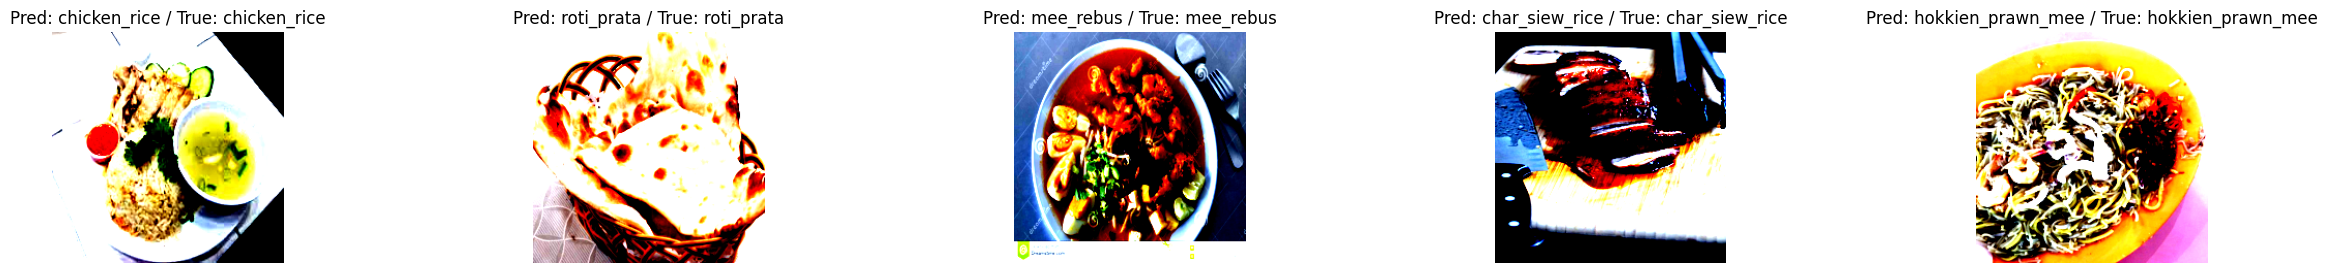

In [26]:
import matplotlib.pyplot as plt
dataset = datasets.ImageFolder('data')
label_names = dataset.classes 

def visualize_predictions(model, test_loader, label_names, num_images=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)  
    model.eval()  

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(30, 3))
    
    # Fetch the first batch of images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)  

    logits = model(images)
    preds = torch.argmax(logits, dim=1)

    for i, ax in enumerate(axes):
        if i >= num_images:  
            break
        img = images[i].cpu().permute(1, 2, 0)
        ax.imshow(img.numpy())
        pred_label = label_names[preds[i].item()]  # Map the prediction index to the label name
        true_label = label_names[labels[i].item()]
        ax.set_title(f'Pred: {pred_label} / True: {true_label}')
        ax.axis('off')
    
    plt.show()
visualize_predictions(model, test_loader, label_names)

In [29]:
import numpy as np
def get_model_probabilities(model, loader, device):
    model.to(device)
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)  
            probabilities = torch.softmax(model(images), dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return np.concatenate(all_probs, axis=0), np.concatenate(all_labels, axis=0)
model_scores, labels = get_model_probabilities(model, test_loader, 'cuda' if torch.cuda.is_available() else 'cpu')

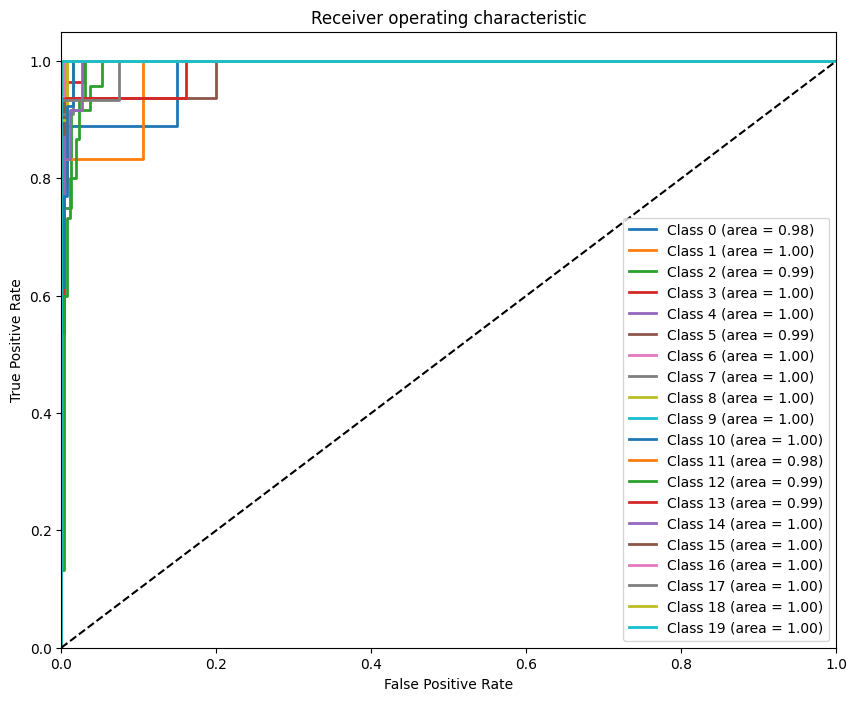

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, scores, num_classes):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((labels == i).astype(int), scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(labels, model_scores, len(label_names))

## Hybrid 

In [5]:
# resnet18 
class HybridCNNTransformer(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.cnn = models.resnet18(pretrained=True)  # Using ResNet18 as the CNN
        self.cnn.fc = nn.Identity()  # Remove the final FC layer
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=1)
        self.classifier = nn.Linear(512, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        for param in self.cnn.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet
        for param in self.transformer.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet

    def forward(self, x):
        cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
        transformer_output = self.transformer(cnn_features).squeeze(1)
        logits = self.classifier(transformer_output)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

In [8]:
model = HybridCNNTransformer()
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback]  
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | accuracy    | MulticlassAccuracy | 0     
1 | cnn         | ResNet             | 11.2 M
2 | transformer | TransformerEncoder | 3.2 M 
3 | classifier  | Linear             | 10.3 K
4 | criterion   | CrossEntropyLoss   | 0     
---------------------------------------------------
10.3 K    Trainable params
14.3 M    Non-trainable params
14.3 M    Total params
57.357    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s, v_num=67, train_acc=0.538, val_loss=1.920, val_acc=0.418]

Epoch 0, global step 40: 'val_loss' was not in top 1


Epoch 1: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s, v_num=67, train_acc=0.600, val_loss=1.470, val_acc=0.515]

Epoch 1, global step 80: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, v_num=67, train_acc=0.500, val_loss=1.290, val_acc=0.573]

Epoch 2, global step 120: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 40/40 [00:16<00:00,  2.50it/s, v_num=67, train_acc=0.458, val_loss=1.180, val_acc=0.622]

Epoch 3, global step 160: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, v_num=67, train_acc=0.577, val_loss=1.110, val_acc=0.640]

Epoch 4, global step 200: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, v_num=67, train_acc=0.486, val_loss=1.070, val_acc=0.652]

Epoch 5, global step 240: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s, v_num=67, train_acc=0.650, val_loss=1.040, val_acc=0.655]

Epoch 6, global step 280: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s, v_num=67, train_acc=0.606, val_loss=1.040, val_acc=0.643]

Epoch 7, global step 320: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, v_num=67, train_acc=0.727, val_loss=1.030, val_acc=0.656]

Epoch 8, global step 360: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, v_num=67, train_acc=0.818, val_loss=1.020, val_acc=0.658]

Epoch 9, global step 400: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s, v_num=67, train_acc=0.750, val_loss=0.998, val_acc=0.667]

Epoch 10, global step 440: 'val_loss' reached 0.99784 (best 0.99784), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=10-val_loss=1.00.ckpt' as top 1


Epoch 11: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s, v_num=67, train_acc=0.850, val_loss=0.997, val_acc=0.683]

Epoch 11, global step 480: 'val_loss' reached 0.99698 (best 0.99698), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=11-val_loss=1.00.ckpt' as top 1


Epoch 12: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s, v_num=67, train_acc=0.867, val_loss=0.989, val_acc=0.684]

Epoch 12, global step 520: 'val_loss' reached 0.98896 (best 0.98896), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=12-val_loss=0.99.ckpt' as top 1


Epoch 13: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s, v_num=67, train_acc=1.000, val_loss=1.000, val_acc=0.689]

Epoch 13, global step 560: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s, v_num=67, train_acc=0.692, val_loss=1.000, val_acc=0.679]

Epoch 14, global step 600: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s, v_num=67, train_acc=0.808, val_loss=0.987, val_acc=0.690]

Epoch 15, global step 640: 'val_loss' reached 0.98704 (best 0.98704), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=15-val_loss=0.99.ckpt' as top 1


Epoch 16: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, v_num=67, train_acc=0.727, val_loss=0.983, val_acc=0.670]

Epoch 16, global step 680: 'val_loss' reached 0.98342 (best 0.98342), saving model to 'D:\\MSBA sem 2\\advanced ML\\project\\src\\checkpoints\\best-checkpoint-epoch=16-val_loss=0.98.ckpt' as top 1


Epoch 17: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s, v_num=67, train_acc=0.850, val_loss=0.988, val_acc=0.684]

Epoch 17, global step 720: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, v_num=67, train_acc=0.750, val_loss=0.992, val_acc=0.682]

Epoch 18, global step 760: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s, v_num=67, train_acc=0.700, val_loss=0.988, val_acc=0.684]

Epoch 19, global step 800: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s, v_num=67, train_acc=0.700, val_loss=0.988, val_acc=0.684]


In [9]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6811813116073608
        test_loss           0.9285343289375305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9285343289375305, 'test_acc': 0.6811813116073608}]

In [20]:
data2 = {
    'Epoch': list(range(20)),
    'train_acc': [0.538, 0.600, 0.500, 0.458, 0.577, 0.486, 0.650, 0.606, 0.727, 0.818, 0.750, 0.850, 0.867, 1.000, 0.692, 0.808, 0.727, 0.850, 0.750, 0.700],
    'val_loss': [1.920, 1.470, 1.290, 1.180, 1.110, 1.070, 1.040, 1.040, 1.030, 1.020, 0.998, 0.997, 0.989, 1.000, 1.000, 0.987, 0.983, 0.988, 0.992, 0.988],
    'val_acc': [0.418, 0.515, 0.573, 0.622, 0.640, 0.652, 0.655, 0.643, 0.656, 0.658, 0.667, 0.683, 0.684, 0.689, 0.679, 0.690, 0.670, 0.684, 0.682, 0.684]
}

df2 = pd.DataFrame(data2)
df2.head()

,Epoch,train_acc,val_loss,val_acc
0,0,0.538,1.92,0.418
1,1,0.600,1.47,0.515
2,2,0.500,1.29,0.573
3,3,0.458,1.18,0.622
4,4,0.577,1.11,0.640


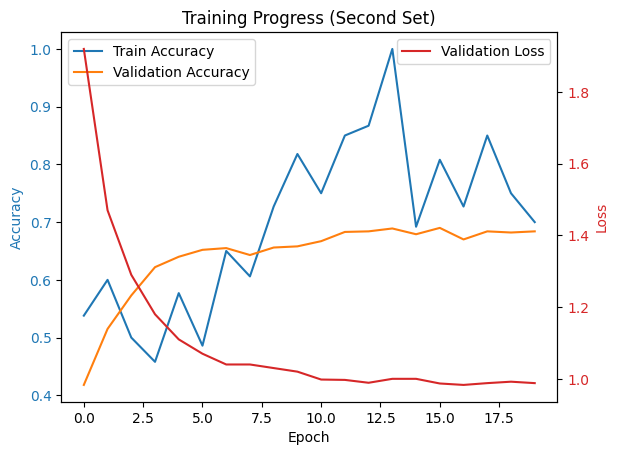

In [21]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(df2['Epoch'], df2['train_acc'], label='Train Accuracy', color='tab:blue')
ax1.plot(df2['Epoch'], df2['val_acc'], label='Validation Accuracy', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(df2['Epoch'], df2['val_loss'], label='Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')
plt.title('Training Progress (Second Set)')
plt.show()

In [10]:
# resnet50 
class HybridCNNTransformer(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.cnn = models.resnet50(pretrained=True)  # Using ResNet18 as the CNN
        self.cnn.fc = nn.Identity()
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=2048, nhead=8), num_layers=1)
        self.classifier = nn.Linear(2048, num_classes)  # Adjust input dim to 2048 for ResNet50
        self.criterion = nn.CrossEntropyLoss()

        for param in self.cnn.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet
        for param in self.transformer.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet

    def forward(self, x):
        cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
        transformer_output = self.transformer(cnn_features).squeeze(1)
        logits = self.classifier(transformer_output)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

In [13]:
model = HybridCNNTransformer()
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback]  
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | accuracy    | MulticlassAccuracy | 0     
1 | cnn         | ResNet             | 23.5 M
2 | transformer | TransformerEncoder | 25.2 M
3 | classifier  | Linear             | 41.0 K
4 | criterion   | CrossEntropyLoss   | 0     
---------------------------------------------------
41.0 K    Trainable params
48.7 M    Non-trainable params
48.7 M    Total params
194.941   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, v_num=69, train_acc=0.314, val_loss=1.180, val_acc=0.584]

Epoch 0, global step 40: 'val_loss' was not in top 1


Epoch 1: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, v_num=69, train_acc=0.795, val_loss=1.080, val_acc=0.620]

Epoch 1, global step 80: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, v_num=69, train_acc=0.867, val_loss=1.080, val_acc=0.636]

Epoch 2, global step 120: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, v_num=69, train_acc=0.727, val_loss=1.080, val_acc=0.663]

Epoch 3, global step 160: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, v_num=69, train_acc=0.800, val_loss=1.070, val_acc=0.660]

Epoch 4, global step 200: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s, v_num=69, train_acc=0.652, val_loss=1.110, val_acc=0.664]

Epoch 5, global step 240: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s, v_num=69, train_acc=0.850, val_loss=1.150, val_acc=0.636]

Epoch 6, global step 280: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s, v_num=69, train_acc=0.864, val_loss=1.120, val_acc=0.651]

Epoch 7, global step 320: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s, v_num=69, train_acc=0.886, val_loss=1.110, val_acc=0.662]

Epoch 8, global step 360: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 40/40 [00:18<00:00,  2.21it/s, v_num=69, train_acc=0.833, val_loss=1.200, val_acc=0.674]

Epoch 9, global step 400: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 40/40 [00:18<00:00,  2.21it/s, v_num=69, train_acc=1.000, val_loss=1.220, val_acc=0.658]

Epoch 10, global step 440: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, v_num=69, train_acc=1.000, val_loss=1.180, val_acc=0.656]

Epoch 11, global step 480: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s, v_num=69, train_acc=1.000, val_loss=1.200, val_acc=0.660]

Epoch 12, global step 520: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 40/40 [00:17<00:00,  2.23it/s, v_num=69, train_acc=1.000, val_loss=1.230, val_acc=0.657]

Epoch 13, global step 560: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s, v_num=69, train_acc=1.000, val_loss=1.240, val_acc=0.645]

Epoch 14, global step 600: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, v_num=69, train_acc=0.864, val_loss=1.240, val_acc=0.631]

Epoch 15, global step 640: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s, v_num=69, train_acc=1.000, val_loss=1.280, val_acc=0.641]

Epoch 16, global step 680: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 40/40 [00:17<00:00,  2.23it/s, v_num=69, train_acc=0.694, val_loss=1.250, val_acc=0.670]

Epoch 17, global step 720: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s, v_num=69, train_acc=0.771, val_loss=1.260, val_acc=0.660]

Epoch 18, global step 760: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s, v_num=69, train_acc=1.000, val_loss=1.330, val_acc=0.646]

Epoch 19, global step 800: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, v_num=69, train_acc=1.000, val_loss=1.330, val_acc=0.646]


In [17]:
model = HybridCNNTransformer.load_from_checkpoint(checkpoint_path="checkpoints/last.ckpt")
trainer.test(model, test_loader)

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
LOCAL_RANK: 0 - CU

Testing DataLoader 0: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6046686768531799
        test_loss           1.1024092435836792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1024092435836792, 'test_acc': 0.6046686768531799}]

In [18]:
import pandas as pd
data = {
    'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    'train_acc': [0.314, 0.795, 0.867, 0.727, 0.800, 0.652, 0.850, 0.864, 0.886, 0.833, 1.000, 1.000, 1.000, 1.000, 1.000, 0.864, 1.000, 0.694, 0.771, 1.000],
    'val_loss': [1.180, 1.080, 1.080, 1.080, 1.070, 1.110, 1.150, 1.120, 1.110, 1.200, 1.220, 1.180, 1.200, 1.230, 1.240, 1.240, 1.280, 1.250, 1.260, 1.330],
    'val_acc': [0.584, 0.620, 0.636, 0.663, 0.660, 0.664, 0.636, 0.651, 0.662, 0.674, 0.658, 0.656, 0.660, 0.657, 0.645, 0.631, 0.641, 0.670, 0.660, 0.646]
}
df = pd.DataFrame(data)
df.head()

,Epoch,train_acc,val_loss,val_acc
0,0,0.314,1.18,0.584
1,1,0.795,1.08,0.620
2,2,0.867,1.08,0.636
3,3,0.727,1.08,0.663
4,4,0.800,1.07,0.660


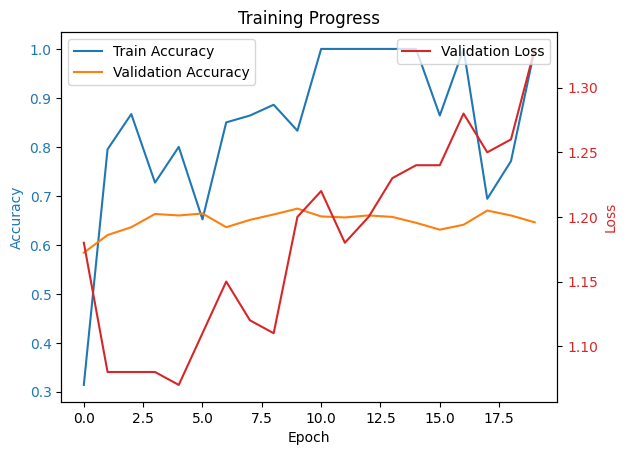

In [19]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(df['Epoch'], df['train_acc'], label='Train Accuracy', color='tab:blue')
ax1.plot(df['Epoch'], df['val_acc'], label='Validation Accuracy', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(df['Epoch'], df['val_loss'], label='Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')
plt.title('Training Progress')
plt.show()

## FPN

In [36]:
class FPN(nn.Module):
    def __init__(self, in_channels):
        super(FPN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.top_layer = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer1 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0)
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.conv1(x))
        c2 = F.relu(self.conv2(c1))
        c3 = F.relu(self.conv3(c2))
        c4 = F.relu(self.conv4(c3))
        p4 = self.top_layer(c4)
        p3 = self._upsample_add(p4, self.latlayer1(c3))
        p2 = self._upsample_add(p3, self.latlayer2(c2))
        p1 = self._upsample_add(p2, self.latlayer3(c1))
        p3 = self.smooth1(p3)
        p2 = self.smooth2(p2)
        p1 = self.smooth3(p1)

        return p1, p2, p3, p4

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True) + y

In [38]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torch.optim import AdamW

class FPNClassifier(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super(FPNClassifier, self).__init__()
        self.save_hyperparameters()
        self.fpn = FPN(in_channels=3)  
        self.classifier = nn.Linear(256, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

    def forward(self, x):
        p1, _, _, _ = self.fpn(x)  
        out = F.adaptive_avg_pool2d(p1, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)
        return {'val_loss': loss, 'val_acc': self.accuracy(logits, y)}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))
        return {'test_loss': loss, 'test_acc': self.accuracy(logits, y)}

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.hparams.learning_rate)

In [39]:
model = FPNClassifier()
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback]  
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | fpn        | FPN                | 2.9 M 
1 | classifier | Linear             | 5.1 K 
2 | criterion  | CrossEntropyLoss   | 0     
3 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.664    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]